In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(
    rc={"figure.figsize":(10, 6.5), 
        "figure.subplot.left":0.10,
        "figure.subplot.right":0.95,
        "figure.subplot.top":0.92,
        }
    )

# No interest in data before this date
start_date = '2013-01-01'

In [2]:
# Load in the electricity data
df_source = pd.read_csv('./datasets/Average_retail_price_of_electricity.csv', skiprows=4)

# Format and clean the electricity dataset
df = df_source.T
df.columns = df.iloc[0]
df.drop(['description', 'units', 'source key'], inplace=True)
df = df.dropna(axis=1)
df['date'] = [pd.to_datetime(x, format="%b %Y") for x in df.index]
#df.tail()

In [3]:
# Load in and clean the cambridge dataset
df_cambridge = pd.read_csv(f"./datasets/cbeci-annualized-consumption.csv")
df_cambridge['date'] = [pd.to_datetime(x) for x in df_cambridge['date']]

# merge the two data sets
df_cambridge = df_cambridge.merge(df, on="date", how="outer")
df_cambridge = df_cambridge.sort_values(by="date")

# Forward fill the energy data (since it's monthly data vs daily)
df_cambridge.fillna(method='ffill', inplace=True)
df_cambridge = df_cambridge.reset_index()
df = df_cambridge

# Filter out data from before our interests
df = df[df['date'] > pd.to_datetime(start_date)]
df = df.reset_index()

In [4]:
df.head()

,level_0,index,date,0.01,0.02,0.03,0.04,0.05,0.06,0.07,...,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,United States : industrial
0,1014,899,2013-01-02,0.446077,0.173960,0.173960,0.050701,0.050701,0.050701,0.050701,...,0.050701,0.050701,0.050701,0.050701,0.050701,0.023960,0.013338,0.013338,0.013338,6.5
1,1015,900,2013-01-03,0.448493,0.174902,0.174902,0.050976,0.050976,0.050976,0.050976,...,0.050976,0.050976,0.050976,0.050976,0.050976,0.029495,0.013410,0.013410,0.013410,6.5
2,1016,901,2013-01-04,0.442051,0.172390,0.172390,0.050244,0.050244,0.050244,0.050244,...,0.050244,0.050244,0.050244,0.050244,0.050244,0.034462,0.013218,0.013218,0.013218,6.5
3,1017,902,2013-01-05,0.440843,0.171919,0.171919,0.050106,0.050106,0.050106,0.050106,...,0.050106,0.050106,0.050106,0.050106,0.050106,0.039181,0.013182,0.013182,0.013182,6.5
4,1018,903,2013-01-06,0.432389,0.168622,0.168622,0.049146,0.049146,0.049146,0.049146,...,0.049146,0.049146,0.049146,0.049146,0.049146,0.043818,0.012929,0.012929,0.012929,6.5


In [5]:
# Create zeroed columns that we can manipulate
df['tracking'] = [0*x for x in df['0.01']]
df['tracking-low'] = df['tracking']

In [6]:
# Interpolate using the energy price (and a low-cost version at 75% price)
# from the energy price to the discrete values in the data set.

def calc_weighted(elec, indx):
    dist = elec % 1
    low = int(elec - dist + 0.1)
    high = low + 1
    
    low_str = "{:.2f}".format(low/100)
    high_str = "{:.2f}".format(high/100)
    return df[low_str][indx]*(1-dist) + df[high_str][indx]*dist

df['tracking'] = [calc_weighted(df['United States : industrial'][x], x) for x in np.arange(0, len(df))]
df['tracking-low'] = [calc_weighted(df['United States : industrial'][x]*0.73, x) for x in np.arange(0, len(df))]

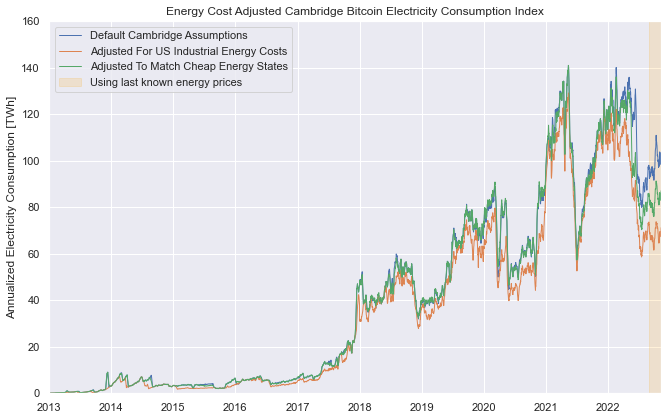

In [7]:
# Plot the interpolated data

sns.lineplot(
        x=df['date'], 
        y=df['0.05'],
        lw=1,
        label='Default Cambridge Assumptions'
) # The default Cambridge assumption is that energy costs are $0.05/kWh

sns.lineplot(
        x=df['date'], 
        y=df['tracking'],
        lw=1,
        label='Adjusted For US Industrial Energy Costs'
) # Data representing if all hash-rate was US and cost industrial prices

sns.lineplot(
        x=df['date'], 
        y=df['tracking-low'],
        lw=1,
        label='Adjusted To Match Cheap Energy States'
)

plt.axvspan(
        xmin=pd.to_datetime(df_source.columns[-1])+pd.Timedelta(30, 'd'),
        #xmax=plt.gca().get_xlim()[1],
        xmax=pd.to_datetime('2100-01-01'),
        color='orange',
        alpha=0.15,
        label='Using last known energy prices'
)

plt.title('Energy Cost Adjusted Cambridge Bitcoin Electricity Consumption Index')
plt.ylabel('Annualized Electricity Consumption [TWh]')
plt.xlabel('') # Intentionally blank
plt.xlim([pd.to_datetime(start_date), pd.to_datetime('2022-11-10')])
plt.ylim([0, 160])
plt.legend()

plt.savefig(f'./tmp-figures/cbeci-adjusted.png', transparent=False, facecolor='w')
plt.show()

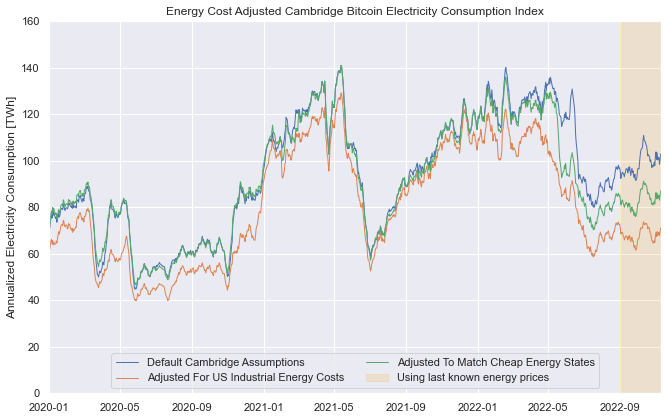

In [8]:
sns.lineplot(
        x=df['date'], 
        y=df['0.05'],
        lw=1,
        label='Default Cambridge Assumptions'
)

sns.lineplot(
        x=df['date'], 
        y=df['tracking'],
        lw=1,
        label='Adjusted For US Industrial Energy Costs'
)

sns.lineplot(
        x=df['date'], 
        y=df['tracking-low'],
        lw=1,
        label='Adjusted To Match Cheap Energy States'
)

plt.axvspan(
        xmin=pd.to_datetime(df_source.columns[-1])+pd.Timedelta(30, 'd'),
        xmax=df['date'][len(df)-1],
        color='orange',
        alpha=0.15,
        label='Using last known energy prices'
)

plt.title('Energy Cost Adjusted Cambridge Bitcoin Electricity Consumption Index')
plt.ylabel('Annualized Electricity Consumption [TWh]')
plt.xlabel('') # Intentionally blank
plt.xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2022-11-10')])
plt.ylim([0, 160])
plt.legend(ncol=2, loc='lower center')

plt.savefig(f'./tmp-figures/cbeci-adjusted-recent.png', transparent=False, facecolor='w')
plt.show()

In [9]:
# Latest Estimates
print(f"Last Cambridge Data Point: {df['date'][len(df['0.05'])-1]}")
print(f"Last EIA Data Point: {df_source.columns[-1]}")
print(f"Cambridge: {df['0.05'][len(df['0.05'])-1]}")
print(f"US Industrial Average: {df['tracking'][len(df['tracking'])-1]}")
print(f"US Cheap Average: {df['tracking-low'][len(df['tracking-low'])-1]}")

# Last check, Cambridge is about a 17% overestimate vs Cheap Energy: 
    # Annual: 103 TWh vs 85 TWh

Last Cambridge Data Point: 2022-11-09 00:00:00
Last EIA Data Point: Aug 2022
Cambridge: 103.0085506
US Industrial Average: 71.2064670452
US Cheap Average: 87.09133558176
